In [ ]:
## Follow the instructions to install the code https://github.com/VIDA-NYU/Perception-training
## Also install the jupyter https://pypi.org/project/jupyter/
## You'll not be able to run with a GPU with less than 12GB of memory
## It's going to take too long to run with CPU 

In [ ]:
1. Evaluating with dataloader and model (interface used for training evaluation)

In [1]:
import math, torch, cv2, matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from step_recog import evaluate, build_model
from step_recog.config import load_config
from step_recog.datasets import Milly_multifeature_v4, collate_fn

def args_hook(cfg_file):
  args = lambda: None
  args.cfg_file = cfg_file
  args.opts = None   
  return args

In [2]:
cfg = args_hook("config/M2.yaml")
cfg = load_config(cfg)

#reads frames and returns features
dataset = Milly_multifeature_v4(cfg, split='test')
data_loader = DataLoader(
        dataset, 
        shuffle=False, 
        batch_size=cfg.TRAIN.BATCH_SIZE,
        collate_fn=collate_fn,
        drop_last=False)

model, _ = build_model(cfg)
weights  = torch.load("models/M2.pt")
model.load_state_dict(weights)

Video: 100%|██████████| 1/1 [00:00<00:00, 29.28it/s, window total=83, padded videos=0]
Using cache found in /home/../.cache/torch/hub/facebookresearch_omnivore_main
/ext3/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ext3/miniconda3/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [3]:
#saves classification report, confusion matrix, and video evaluation (image with ground-truth, predicted and confidence)
evaluate(model, data_loader, cfg)

WARNING ⚠️ NMS time limit 0.550s exceeded


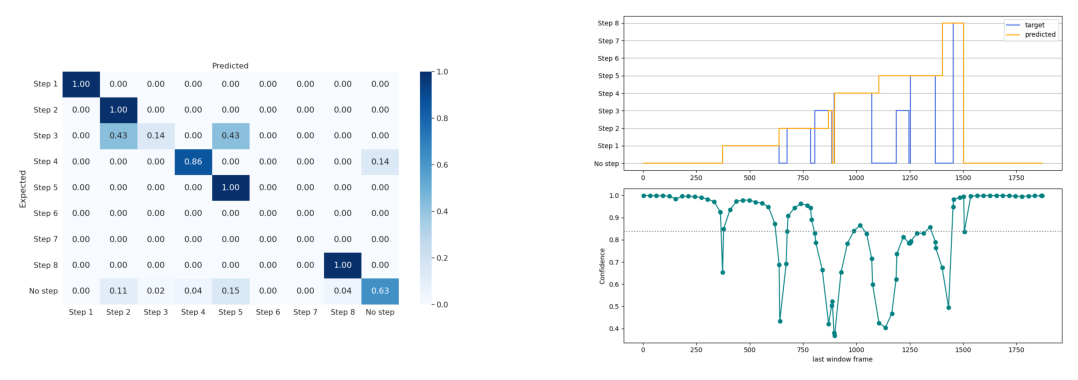

In [4]:
cm = cv2.imread("output/confusion_matrix.png")
cm = cv2.cvtColor(cm, cv2.COLOR_BGR2RGB)

video_eval = cv2.imread("output/video_evaluation/M2-19-step_variation.png")
video_eval = cv2.cvtColor(video_eval, cv2.COLOR_BGR2RGB)

figure = plt.figure(figsize = (1366 / 100, 768 / 100), dpi = 100)  
plt.subplot(1, 2, 1)
plt.imshow(cm)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(video_eval)
plt.axis('off')

plt.show()

In [5]:
metrics = open("output/metrics.txt")
metrics = metrics.read()
print(metrics)

              precision    recall  f1-score   support

      Step 1       1.00      1.00      1.00        10
      Step 2       0.38      1.00      0.56         5
      Step 3       0.50      0.14      0.22         7
      Step 4       0.75      0.86      0.80         7
      Step 5       0.33      1.00      0.50         5
      Step 6       0.00      0.00      0.00         0
      Step 7       0.00      0.00      0.00         0
      Step 8       0.60      1.00      0.75         3
     No step       0.97      0.63      0.76        46

    accuracy                           0.71        83
   macro avg       0.50      0.63      0.51        83
weighted avg       0.83      0.71      0.72        83


Categorical accuracy: 0.71
Weighted accuracy: 0.80
Balanced accuracy: 0.80



In [ ]:
2. Evaluating with StepPredictor and ProcedureStateMachine (interface used by BBN)

In [6]:
import supervision as sv, tqdm, torch, numpy as np, ipdb, pandas as pd

from step_recog.full.model import StepPredictor
from step_recog.full.statemachine import ProcedureStateMachine

In [7]:
video_path   = "videos/M2-19.mp4"
video_info   = sv.VideoInfo.from_video_path(video_path)
step_process = video_info.fps #1 second by default

model = StepPredictor("config/M2.yaml", video_info.fps).to("cuda")
psm   = ProcedureStateMachine(model.cfg.MODEL.OUTPUT_DIM)

Using cache found in /home/../.cache/torch/hub/facebookresearch_omnivore_main


In [9]:
prob_step = np.zeros(model.cfg.MODEL.OUTPUT_DIM + 1)
prob_step[-1] = 1.0
step_desc = "No step"

window_prediction = {"window_end_frame": [], "window_end_sec": [], "step_idx": [], "step_desc": [], "step_state": []}
model.reset()
psm.reset()

#Iterates over one video
for idx, frame in tqdm.tqdm(enumerate(sv.get_video_frames_generator(video_path))):    
  frame_aux = model.prepare(frame)
  model.queue_frame(frame_aux)

  if idx % step_process == 0:
    prob_step = model(frame_aux, queue_omni_frame = False).cpu().squeeze().numpy()        
    step_idx  = np.argmax(prob_step)
    step_desc = "No step" if step_idx >= len(model.STEPS) else model.STEPS[step_idx]      

  #Most important output for BBN personnel
  psm.process_timestep(prob_step)

  window_prediction["window_end_frame"].append(idx)
  window_prediction["window_end_sec"].append(idx / video_info.fps)
  window_prediction["step_idx"].append(step_idx)
  window_prediction["step_desc"].append(step_desc)
  current_state = psm.current_state.copy()
  window_prediction["step_state"].append(current_state)

window_prediction = pd.DataFrame(window_prediction)
print(window_prediction)

1870it [00:24, 74.98it/s]

      window_end_frame  window_end_sec  step_idx step_desc  \
0                    0        0.000000         8   No step   
1                    1        0.033333         8   No step   
2                    2        0.066667         8   No step   
3                    3        0.100000         8   No step   
4                    4        0.133333         8   No step   
...                ...             ...       ...       ...   
1865              1865       62.166667         8   No step   
1866              1866       62.200000         8   No step   
1867              1867       62.233333         8   No step   
1868              1868       62.266667         8   No step   
1869              1869       62.300000         8   No step   

                    step_state  
0     [0, 0, 0, 0, 0, 0, 0, 0]  
1     [0, 0, 0, 0, 0, 0, 0, 0]  
2     [0, 0, 0, 0, 0, 0, 0, 0]  
3     [0, 0, 0, 0, 0, 0, 0, 0]  
4     [0, 0, 0, 0, 0, 0, 0, 0]  
...                        ...  
1865  [2, 2, 2, 2, 2, 0,

In [ ]:
3. Evaluating with visualize.py (it uses StepPredictor and ProcedureStateMachine)

In [ ]:
#Plots a histogram on the lef-top of the video with: step probatilities and states
!python ../step_recog/full/visualize.py videos/M2-19.mp4 output/out.mp4 ../config/M2.yaml